In [1]:
import os
import itertools
import sys
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import math 

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications.resnet import ResNet50
from keras import backend as K
from keras.callbacks import Callback
from keras.layers import Dense, Dropout
from keras.models import Model
from PIL import Image
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score)

from shutil import rmtree
import xml.etree.ElementTree as ET
import random

%matplotlib inline

In [2]:
baseDir=""

def split_cases(reports_images, reports_text, keys, filename):
    new_images = {}

    for key in keys:
        for image in reports_images[key]:
            new_images[image] = reports_text[key]

    with open(filename, "w") as output_file:
        for new_image in new_images:
            output_file.write(new_image + "\t" + new_images[new_image])
            output_file.write("\n")
            
# create dataset folder
try:
    rmtree(baseDir+"iu_xray/")
except BaseException:
    pass
os.makedirs(baseDir+"iu_xray/")

# create folder for images
os.makedirs(baseDir+"iu_xray/iu_xray_images/")

# unzip
os.system("tar -xzf ../input/iuxray-load/iu_xray/NLMCXR_png.tgz -C "+baseDir+"iu_xray/iu_xray_images/")
os.system("tar -xzf ../input/iuxray-load/iu_xray/NLMCXR_reports.tgz -C "+baseDir+"iu_xray/")

# read the reports xml files and create the dataset tsv
reports_path = baseDir+"iu_xray/ecgen-radiology"

reports = os.listdir(reports_path)

reports.sort()

reports_with_no_image = []
reports_with_empty_sections = []
reports_with_no_impression = []
reports_with_no_findings = []

images_captions = {}
images_major_tags = {}
images_auto_tags = {}
reports_with_images = {}
text_of_reports = {}

for report in reports:
    tree = ET.parse(os.path.join(reports_path, report))
    root = tree.getroot()
    img_ids = []
    # find the images of the report
    images = root.findall("parentImage")
    # if there aren't any ignore the report
    if len(images) == 0:
        reports_with_no_image.append(report)
    else:
        sections = root.find("MedlineCitation").find("Article").find("Abstract").findall("AbstractText")
        # find impression and findings sections
        for section in sections:
            if section.get("Label") == "FINDINGS":
                findings = section.text
            if section.get("Label") == "IMPRESSION":
                impression = section.text

        if impression is None and findings is None:
            reports_with_empty_sections.append(report)
        else:
            if impression is None:
                reports_with_no_impression.append(report)
                caption = findings
            elif findings is None:
                reports_with_no_findings.append(report)
                caption = impression
            else:
                caption = impression + " " + findings

            # get the MESH tags
            tags = root.find("MeSH")
            major_tags = []
            auto_tags = []
            if tags is not None:
                major_tags = [t.text for t in tags.findall("major")]
                auto_tags = [t.text for t in tags.findall("automatic")]

            for image in images:
                iid = image.get("id") + ".png"
                images_captions[iid] = caption
                img_ids.append(iid)
                images_major_tags[iid] = major_tags
                images_auto_tags[iid] = auto_tags

            reports_with_images[report] = img_ids
            text_of_reports[report] = caption

print("Found", len(reports_with_no_image), "reports with no associated image")
print("Found", len(reports_with_empty_sections), "reports with empty Impression and Findings sections")
print("Found", len(reports_with_no_impression), "reports with no Impression section")
print("Found", len(reports_with_no_findings), "reports with no Findings section")

print("Collected", len(images_captions), "image-caption pairs")

with open(baseDir+"iu_xray/iu_xray.tsv", "w") as output_file:
    for image_caption in images_captions:
        output_file.write(image_caption + "\t" + images_captions[image_caption])
        output_file.write("\n")

# Safer JSON storing
with open(baseDir+"iu_xray/iu_xray_captions.json", "w") as output_file:
    output_file.write(json.dumps(images_captions))
with open(baseDir+"iu_xray/iu_xray_major_tags.json", "w") as output_file:
    output_file.write(json.dumps(images_major_tags))
with open(baseDir+"iu_xray/iu_xray_auto_tags.json", "w") as output_file:
    output_file.write(json.dumps(images_auto_tags))

# perform a case based split
random.seed(42)
keys = list(reports_with_images.keys())
random.shuffle(keys)

train_split = int(np.floor(len(reports_with_images) * 0.9))

train_keys = keys[:train_split]
test_keys = keys[train_split:]

train_path = baseDir+"iu_xray/train_images.tsv"
test_path = baseDir+"iu_xray/test_images.tsv"

split_cases(reports_with_images, text_of_reports, train_keys, train_path)
split_cases(reports_with_images, text_of_reports, test_keys, test_path)


os.listdir(baseDir+"iu_xray")

Found 104 reports with no associated image
Found 25 reports with empty Impression and Findings sections
Found 6 reports with no Impression section
Found 489 reports with no Findings section
Collected 7430 image-caption pairs


['iu_xray_captions.json',
 'iu_xray_auto_tags.json',
 'test_images.tsv',
 'iu_xray_major_tags.json',
 'ecgen-radiology',
 'train_images.tsv',
 'iu_xray.tsv',
 'iu_xray_images']

In [3]:
# !pip install matplotlib
# !pip install sklearn
# !pip install pandas

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
baseDir = "./iu_xray/"

In [5]:
def getTrainAndTestDicts():
    train = pd.read_csv(baseDir+"train_images.tsv", sep='\t', names=['filename'], usecols=['filename'])
    test = pd.read_csv(baseDir+"test_images.tsv", sep='\t', names=['filename'], usecols=['filename'])

    with open(baseDir+'iu_xray_auto_tags.json') as json_file:
        auto_tags_dict = json.load(json_file)

    auto_tags_list = []
    for key, value in auto_tags_dict.items():
        auto_tags_dict[key] = [v.lower() for v in value]

    auto_tags_df = pd.DataFrame.from_dict([auto_tags_dict]).T
    auto_tags_df.reset_index( inplace=True)
    auto_tags_df.columns = ["filename","labels"]
    
    train = pd.merge(train,auto_tags_df,on='filename')
    test = pd.merge(test,auto_tags_df,on='filename')
    
    train_dict = {}
    for index, row in train.iterrows():
        train_dict[row['filename'] ]= row['labels']

    test_dict = {}
    for index, row in test.iterrows():
        test_dict[row['filename'] ]= row['labels']
    
    return train_dict, test_dict

In [6]:
# from keras.applications.densenet import preprocess_input
# from keras.applications.resnet import preprocess_input

import keras
from keras.preprocessing import image
from tqdm import tqdm
import math

def load_data(data, concepts_list):
    """
    function that loads the images and tags in NumPy arrays.
    Tags become one-hot encoded.
    :param data: the data dictionary to be loaded into the arrays.
    :param concepts_list: the list of tags.
    :return: data as (X,y) that can be used in training.
    """
    x_data, y_data = [], []
    # read the data file
    for img_id in tqdm(data.keys()):
        image_path = os.path.join(baseDir+"iu_xray_images/", img_id)
        img = image.load_img(image_path, target_size=(224, 224))  # load PIL image.
        x = image.img_to_array(img)  # turn the PIL image to NumPy array.
        x = keras.applications.resnet.preprocess_input(x)  # mean and std of ImageNet, also [0,1] values.
        # encode the tags
        concepts = np.zeros(len(concepts_list), dtype=int)
        if len(data[img_id]) != 0:
            image_concepts = data[img_id]
        else:
            image_concepts = []
        for i in range(0, len(concepts_list)):
            # if the tag is assigned to the image put 1 in its position in the true binary vector
            if concepts_list[i] in image_concepts:
                concepts[i] = 1  # 1-hot encoding.
        x_data.append(x)
        y_data.append(concepts)
    # creates images and labels
    return np.array(x_data), np.array(y_data)

def dataNconcepts(path):
#     with open(path) as json_file:
#         auto_tags_dict = json.load(json_file)  
#     train_dict = dict(list(auto_tags_dict.items())[:int(len(auto_tags_dict)*0.8)])
#     valid_dict = dict(list(auto_tags_dict.items())[int(len(auto_tags_dict)*0.8):int(len(auto_tags_dict)*0.9)])
#     test_dict =  dict(list(auto_tags_dict.items())[int(len(auto_tags_dict)*0.9):])
   
    train_dict_old,test_dict = getTrainAndTestDicts()
    sliceIdx = int(len(train_dict_old)*0.888)
    train_dict = dict(list(train_dict_old.items())[:sliceIdx])
    valid_dict = dict(list(train_dict_old.items())[sliceIdx:])
    
    print(len(train_dict),len(valid_dict),len(test_dict))
    
    train_concepts = []
    for key, value in train_dict.items():
        for v in value:
            if v not in train_concepts:
                train_concepts.append(v)

    valid_concepts = []
    for key, value in valid_dict.items():
        for v in value:
            if v not in valid_concepts:
                valid_concepts.append(v)

    test_concepts = []
    for key, value in test_dict.items():
        for v in value:
            if v not in test_concepts:
                test_concepts.append(v)

    return train_dict, train_concepts, valid_dict, valid_concepts, test_dict, test_concepts

def generator( images, labels, batch_size, num_tags):
    num_of_batches = math.ceil(len(images) / batch_size)
    while True:
        lists = list(zip(images, labels))
        np.random.shuffle(lists)
        images, labels = zip(*lists)
        for batch in range(num_of_batches):
            if len(images) - (batch * batch_size) < batch_size:
                current_batch_size = len(images) - (batch * batch_size)
            else:
                current_batch_size = batch_size
            batch_features = np.zeros((current_batch_size, 224, 224, 3))
            batch_labels = np.zeros((current_batch_size, num_tags))

            for i in range(batch_size):
                index = (batch * batch_size) + i
                if index < len(images):
                    batch_features[i] = images[index]
                    batch_labels[i] = labels[index]
            yield batch_features, batch_labels

In [7]:
train_data, train_concepts, val_data, val_concepts, test_data, test_concepts = dataNconcepts(baseDir+'iu_xray_auto_tags.json')

x_train, y_train = load_data(train_data, train_concepts)
x_val, y_val = load_data(val_data, train_concepts)
x_test, y_test = load_data(test_data, train_concepts)

classes = len(train_concepts)

5926 748 756


100%|██████████| 756/756 [00:03<00:00, 228.65it/s]


In [8]:
y_train.shape

(5926, 523)

In [9]:
# from keras.applications.densenet import preprocess_input

# train = pd.read_csv(baseDir+"train_images.tsv", sep='\t', names=['filename'], usecols=['filename'])
# test = pd.read_csv(baseDir+"test_images.tsv", sep='\t', names=['filename'], usecols=['filename'])

# with open(baseDir+'iu_xray_auto_tags.json') as json_file:
#     auto_tags_dict = json.load(json_file)

# auto_tags_list = []
# for key, value in auto_tags_dict.items():
#     auto_tags_dict[key] = [v.lower() for v in value]

# auto_tags_df = pd.DataFrame.from_dict([auto_tags_dict]).T
# auto_tags_df.reset_index( inplace=True)
# auto_tags_df.columns = ["filename","labels"]

# train = pd.merge(train,auto_tags_df,on='filename')
# test = pd.merge(test,auto_tags_df,on='filename')


# # 3 data generators
# from keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt

# datagen=ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input, validation_split=0.11)

# train_generator=datagen.flow_from_dataframe(
#     dataframe=train,
#     directory= baseDir + "iu_xray_images",
#     x_col='filename',
#     y_col='labels',
#     subset="training",
#     batch_size=32,
#     seed=10,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(224, 224)
# )

# valid_generator=datagen.flow_from_dataframe(
#     dataframe=train,
#     directory= baseDir + "iu_xray_images",
#     x_col='filename',
#     y_col='labels',
#     subset="validation",
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(224, 224)
# )

# test_datagen=ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)

# test_generator=test_datagen.flow_from_dataframe(
#     dataframe=test,
#     directory= baseDir + "iu_xray_images",
#     x_col='filename',
#     y_col=None,
#     batch_size=32,
#     seed=10,
#     shuffle=False,
#     class_mode=None,
#     target_size=(128, 128)
# )

# label_to_class = {v: k for k, v in train_generator.class_indices.items()}
# classes = len(label_to_class)
# print(classes)

In [10]:
# import tensorflow as tf
# from sklearn.metrics import f1_score

# class Metrics(tf.keras.callbacks.Callback):
#     def __init__(self, train_data, valid_data):
#         super(Metrics, self).__init__()
#         self.train_data = train_data
#         self.validation_data = valid_data

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
        
#         _val_f1 = f1_score(y_val, (self.model.predict(x_val, batch_size = 16) > 0.5).astype('int'),average="weighted")
#         _f1 = f1_score(y_train , (self.model.predict(x_train, batch_size = 16) > 0.5).astype('int') ,average="weighted")

#         logs['val_f1'] = _val_f1
#         logs['f1'] = _f1
 
#         print(" — val_f1: %f — train_f1: %f" % (_val_f1, _f1,))
#         return

In [11]:
import tensorflow as tf
from keras.applications.resnet import ResNet101

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

def make_model():
    base_model = ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=None,
        pooling='max'
    )

#     for layer in base_model.layers:
#         layer.trainable = False

    dense = Dropout(0.5)(base_model.output)
    dense = Dense(base_model.outputs[0].shape[1]/2)(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(classes, activation='sigmoid')(dense)

    model = Model(inputs=base_model.input, outputs=dense)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
        
    )
    return model

model = make_model()
model.summary()

2021-12-19 09:39:34.889103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 09:39:34.971127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 09:39:34.971796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 09:39:34.973137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
import tensorflow as tf
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')
batch_size = 64


with tf.device('/device:GPU:0'):
#     metrics = Metrics((x_train,y_train), (x_val,y_val) )

    checkpoint = ModelCheckpoint(
        "./thesisCNNFoiWeights2.ckpt",
        monitor='val_precision',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )


    history = model.fit(
    generator(x_train, y_train, batch_size, len(train_concepts)),
    steps_per_epoch=math.ceil(len(x_train) / batch_size),
    epochs = 50,
    validation_data = generator(x_val, y_val, batch_size, len(train_concepts)),
    validation_steps=math.ceil(len(x_val) / batch_size),
    callbacks = [ checkpoint]
    )
    
#     history = model.fit(
#     x = train_generator,
#     batch_size = 256,
#     epochs = 50,
#     validation_data = valid_generator,
#     callbacks = [ checkpoint])


Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/50


2021-12-19 09:39:40.071767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 09:39:51.437308: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 73s 603ms/step - loss: 0.1714 - accuracy: 0.0351 - precision: 0.0058 - recall: 0.0242 - val_loss: 2730.4160 - val_accuracy: 0.4318 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_precision improved from -inf to 0.00000, saving model to ./thesisCNNFoiWeights2.ckpt
Epoch 2/50
93/93 [==============================] - 53s 572ms/step - loss: 0.0226 - accuracy: 0.0418 - precision: 0.0579 - recall: 0.0054 - val_loss: 2.9136 - val_accuracy: 0.2299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_precision did not improve from 0.00000
Epoch 3/50
93/93 [==============================] - 53s 572ms/step - loss: 0.0195 - accuracy: 0.0429 - precision: 0.0883 - recall: 0.0045 - val_loss: 0.0239 - val_accuracy: 0.1043 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00003: val_precision did not improve from 0.00000
Epoch 4/50
93/93 [==============================] - 53s 572ms/step - loss: 0.0198 - accuracy

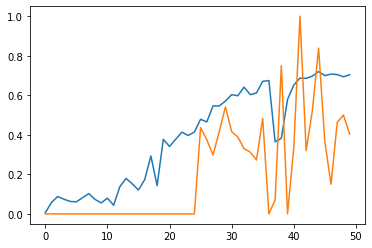

In [13]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])


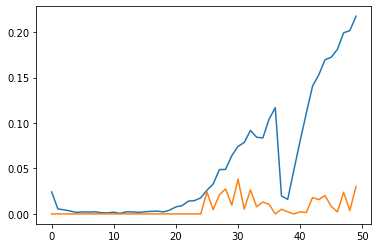

In [14]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])


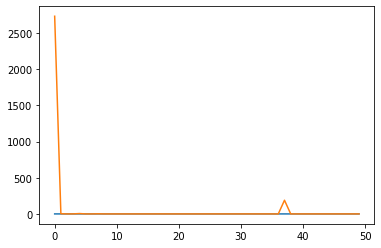

In [15]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


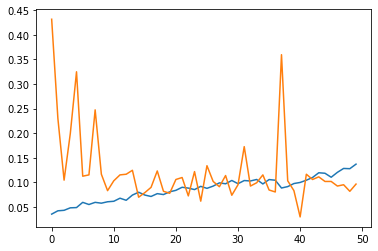

In [16]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])



In [17]:
# model.save('./thesisModelFoi3')

In [18]:
model.load_weights("./thesisCNNFoiWeights2.ckpt")

In [19]:
model.evaluate(x_train, y_train)

2021-12-19 10:24:37.635050: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3568115712 exceeds 10% of free system memory.
2021-12-19 10:24:41.540718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3568115712 exceeds 10% of free system memory.


186/186 [==============================] - 20s 98ms/step - loss: 0.0148 - accuracy: 0.1352 - precision: 0.9241 - recall: 0.0357


[0.014832942746579647,
 0.13516706228256226,
 0.924119234085083,
 0.035718027502298355]

In [20]:
model.evaluate(x_val, y_val)

2021-12-19 10:25:06.550359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 450379776 exceeds 10% of free system memory.


24/24 [==============================] - 2s 100ms/step - loss: 0.0221 - accuracy: 0.1056 - precision: 1.0000 - recall: 0.0015


[0.022147199138998985, 0.10561497509479523, 1.0, 0.0015117158181965351]

In [21]:
model.evaluate(x_test, y_test)

2021-12-19 10:25:09.239398: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 455196672 exceeds 10% of free system memory.
2021-12-19 10:25:09.786171: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 455196672 exceeds 10% of free system memory.


24/24 [==============================] - 2s 103ms/step - loss: 0.0185 - accuracy: 0.0913 - precision: 0.5000 - recall: 0.0036


[0.01851465366780758, 0.0912698432803154, 0.5, 0.003597122384235263]

In [22]:
# import keras 

# new_model = keras.models.load_model('/content/drive/MyDrive/models/checkpoints/thesisModel')
# new_model.evaluate(test_generator)

In [23]:
# gen_1 = get_valid_gen()
# gen_2 = get_valid_gen()

# for i in range(len(gen_1)):
#     x,y = next(gen_1)    
#     if i == 0:
#         pred_y = model.predict(x)
#         true_y = y
#     else:
#         pred_y = np.vstack( (pred_y, model.predict(x)) )
#         true_y = np.vstack(( true_y, y ))


# pred_y2 = model.predict(gen_2)
# (pred_y==pred_y2).all()

In [24]:
# import imageio


In [25]:
# train_imgs = []
# train_labels = []
# for index, row in df.iterrows():

#     path = row['filename']
#     label = row['labels']

#     img = imageio.imread('./myimage.jpg')

#     imgs.append(img)
#     labels.append(label)


# test_imgs = []
# test_labels = []
# for index, row in df.iterrows():

#     path = row['filename']
#     label = row['labels']

#     img = imageio.imread('./myimage.jpg')
    
#     imgs.append(img)
#     labels.append(label)

In [26]:
# from sklearn.model_selection import train_test_split

# train_imgs, dev_imgs, train_labels, dev_labels = train_test_split(train_imgs, train_labels, test_size=0.11, shuffle=False )